In [252]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web
import yfinance as yf
# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.tseries.offsets import BDay
from datetime import date

from typing import Tuple, List
# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

In [253]:
df = pd.read_csv("../data/stock_indicators.csv")
df.head()

,Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaN,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaN,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,KROGER CO,KR,NaN,2021-01-23 00:00:00,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [254]:
date_cols= ["Date Became Aware of Breach", "Date of Disclosure"]
df[date_cols] = df[date_cols].apply(lambda x: pd.to_datetime(x, errors="coerce"))


In [255]:
df["Date of Disclosure"].isna().sum()

0

In [256]:
max_normal_range = 1000
max_event_range = 10

earliest_breach_date = min(df["Date of Disclosure"])
latest_breach_date = max(df["Date of Disclosure"])
sp_start = earliest_breach_date - pd.to_timedelta(max_normal_range, unit="D")
sp_end = date.today()

In [257]:
sp500 = yf.download("^GSPC", start=sp_start, end=sp_end)

[*********************100%***********************]  1 of 1 completed


In [258]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-09-27,1007.039978,1018.919983,998.239990,1018.609985,1018.609985,1467000000
2001-09-28,1018.609985,1040.939941,1018.609985,1040.939941,1040.939941,1631500000
2001-10-01,1040.939941,1040.939941,1026.760010,1038.550049,1038.550049,1175600000
2001-10-02,1038.550049,1051.329956,1034.469971,1051.329956,1051.329956,1289800000
2001-10-03,1051.329956,1075.380005,1041.479980,1072.280029,1072.280029,1650600000


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

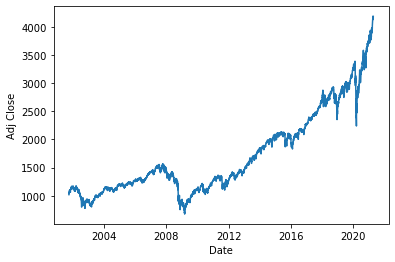

In [259]:
sns.lineplot(data=sp500, x="Date", y="Adj Close")

In [268]:
def window_date(date: datetime.datetime, window=(0, 0)):
    return (
        date + pd.to_timedelta(window[0], unit="D"), 
        date + pd.to_timedelta(window[1], unit="D")
    )

def date_range(df, window_dates: Tuple[datetime.datetime, datetime.datetime]):
    return df.loc[(df.index > window_dates[0]) & (df.index <= window_dates[1])]

def market_model(stock, sp500, window_date):
    # Normal Model Estimation
    window_sp500 = date_range(sp500, window_date)
    window_stock = date_range(stock, window_date)
    
    # pct_change - first entry is always nan
    sp500_returns = window_sp500["Adj Close"].pct_change()[1:].values.reshape(-1, 1) # "X"
    stock_returns = window_stock["Adj Close"].pct_change()[1:].values.reshape(-1, 1) # "Y"
    
    reg = LinearRegression()
    
    reg.fit(sp500_returns, stock_returns)
    (alpha, beta) = reg.intercept_.item(), reg.coef_.item()
    
    stock_returns_pred = reg.predict(sp500_returns)
    
    mse = mean_squared_error(stock_returns, stock_returns_pred)
    r2 = r2_score(stock_returns, stock_returns_pred)
    
    # Reformatted
    sp_ret = sp500_returns.ravel()
    st_ret = stock_returns.ravel()
    sp_ret = np.insert(sp_ret, 0, np.nan)
    st_ret = np.insert(st_ret, 0, np.nan)

    dat = pd.DataFrame({
        "sp500": window_sp500["Adj Close"], 
        "window_stock": window_stock["Adj Close"], 
        "sp500_returns": sp_ret,
        "stock_returns": st_ret,
    }, index=window_sp500["Adj Close"].index)
    
    return {
        "alpha": alpha,
        "beta": beta,
        "mse": mse,
        "r2": r2,
        "data": dat
    }


In [283]:
saves = {}

def normal_return_model(row, est_window=(-200, -7), event_window=(-7, 7), windows = [], coerce=True, debug=True):
    if est_window[0] > est_window[1] or event_window[0] > event_window[1]:
        raise ValueError("Invalid Window: Windows must be in form (a, b), a < b")
    if est_window[1] > event_window[0]:
        raise ValueError("Overlapping windows!")
        
    ticker = row["Ticker"]
    disclosure_date = row["Date of Disclosure"]
    
    # Convert windows to date windows
    est_window_date = window_date(disclosure_date, est_window)
    event_window_date = window_date(disclosure_date, event_window)
    
    start_date = est_window_date[0]
    end_date = event_window_date[1]
    
    # Ensure dates are valid
    today_date = datetime.date.today()
    if end_date > today_date:
        if coerce:
            end_date = today_date
        else:
            raise ValueError(
                f"Ending interval of {end_date.strftime('%Y-%m-%d')} is later than today {today_date.strftime('%Y-%m-%d')}"
            )
    
    if debug:
        print(f"Ticker: {row['Ticker']}")
        print(f"Date of Disclosure: {row['Date of Disclosure'].strftime('%Y-%m-%d')}")
        print(f"estimation window: {est_window_date}")
        print(f"event window: {event_window_date}")
    # Download
    raw_prices = yf.download(ticker, start=start_date, end=end_date)
    
    # Linear Regression
    results = market_model(raw_prices, sp500, est_window_date)
    saves["results"] = results
    alpha, beta = results["alpha"], results["beta"]
    
    # Draw
    if debug:
        model_df = results["data"]
        saves["model_df"] = model_df
#         plt.scatter(model_df["sp500_returns"], model_df["stock_returns"], color='black')
#         plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)
    
    # Event interval
    event_df = pd.DataFrame()
    event_df["actual"] = date_range(raw_prices, event_window_date)["Adj Close"].pct_change()[1:]
    event_df["sp500"] = date_range(sp500, event_window_date)["Adj Close"].pct_change()[1:]
    event_df["normal"] = alpha + beta * event_df["sp500"]
    event_df["abnormal"] = event_df["actual"] - event_df["normal"]
    
    # Compute CARs
    
    CAR = {}
    for w in windows:
        dates = window_date(disclosure_date, w)
        CAR[w] = date_range(event_df["abnormal"], dates).sum()
    print(event_df)
    
#     event_data = pd.concat(actual_returns, sp500_returns, axis=1) 
#     print(event_data)
    return {
        "market_model": results,
        "event_df": event_df,
        "CAR": CAR,
    }

normal_return_model(df.iloc[0], windows = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)], debug=False)


[*********************100%***********************]  1 of 1 completed
              actual     sp500    normal  abnormal
Date                                              
2021-02-22  0.007906 -0.007733 -0.007562  0.015468
2021-02-23 -0.004212  0.001256 -0.000560 -0.003652
2021-02-24  0.008221  0.011352  0.007303  0.000918
2021-02-25 -0.002124 -0.024479 -0.020606  0.018482
2021-02-26 -0.002470 -0.004750 -0.005239  0.002769
2021-03-01  0.013881  0.023791  0.016993 -0.003111
2021-03-02  0.003585 -0.008081 -0.007833  0.011418
2021-03-03 -0.009552 -0.013066 -0.011716  0.002164


{'market_model': {'alpha': -0.0015385439389502442,
  'beta': 0.7789226842695007,
  'mse': 0.0002722498639160231,
  'r2': 0.20094690819228223,
  'data':                   sp500  window_stock  sp500_returns  stock_returns
  Date                                                               
  2020-08-10  3360.469971    417.773438            NaN            NaN
  2020-08-11  3333.689941    413.802277      -0.007969      -0.009506
  2020-08-12  3380.350098    418.071960       0.013997       0.010318
  2020-08-13  3373.429932    417.514648      -0.002047      -0.001333
  2020-08-14  3372.850098    420.022705      -0.000172       0.006007
  2020-08-17  3381.989990    418.022247       0.002710      -0.004763
  2020-08-18  3389.780029    415.195679       0.002303      -0.006762
  2020-08-19  3374.850098    416.021729      -0.004404       0.001990
  2020-08-20  3385.510010    412.000854       0.003159      -0.009665
  2020-08-21  3397.159912    416.808014       0.003441       0.011668
  2020-08-

In [ ]:
result_df = df.copy()
for i, row in df.iterrows():
    result = normal_return_model(df.iloc[0], windows = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)], debug=False)
    result_df[""]


In [280]:
tester = {}
tester[(0, 1)] = 1
tester

{(0, 1): 1}

<AxesSubplot:xlabel='Date', ylabel='value'>

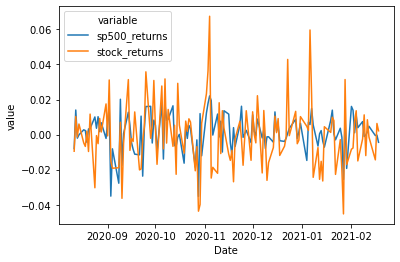

In [272]:
model_df = saves["results"]["data"]
alpha = saves["results"]["alpha"]
beta = saves["results"]["beta"]
model_df.head()

melted = pd.melt(model_df, ignore_index=False)
melted.head()

cols = ["sp500_returns", "stock_returns"]
filtered = melted[melted["variable"].isin(cols)]

# filtered.tail(100)
sns.lineplot(data=filtered, x=filtered.index, y="value", hue="variable")

<AxesSubplot:xlabel='sp500_returns', ylabel='stock_returns'>

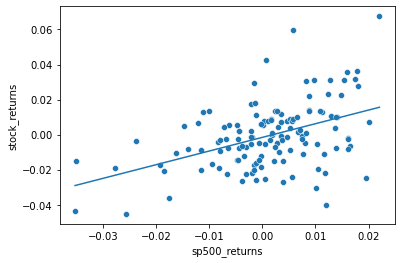

In [273]:
sp500_returns = model_df["sp500_returns"]
stock_returns = model_df["stock_returns"]

sns.scatterplot(data=model_df, x="sp500_returns", y="stock_returns")
X = sp500_returns.values
Y = alpha + beta * X
sns.lineplot(x=X, y=Y)

In [265]:
# pd.set_option("display.max_rows", None)

# display(sp500)
row = df.iloc[0]
disclosure_date = row["Date of Disclosure"]
print(disclosure_date)
event_window=(-3, 5)

window = window_date(disclosure_date, event_window)
print(window[0])
print(window[1])
adj_close = date_range(sp500, window)["Adj Close"]


2021-02-25 00:00:00
2021-02-22 00:00:00
2021-03-02 00:00:00
